In [49]:
import pandas as pd
import numpy as np
import pickle
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
import sentence_transformers
import matplotlib.pyplot as plt
import seaborn as sns
from yellowbrick.text import TSNEVisualizer

from sklearn.decomposition import PCA
import scipy.sparse
import sys
sys.path.insert(1, '/Users/piyush/Desktop/dsml_Portfolio/podcast/final_push')
from config import PODCASTS_DATABASE_PATH_RAW, USER_REVIEWS_DATABASE_PATH_RAW, PODCASTS_DATABASE_PATH_PROCESSED, USER_REVIEWS_DATABASE_PATH_PROCESSED
#from preprocessing import get_preprocessed_text
from sklearn.metrics.pairwise import cosine_similarity, manhattan_distances, euclidean_distances
from tqdm import tqdm


# Loading data 
df_podcasts = pd.read_csv(PODCASTS_DATABASE_PATH_RAW,header=None)
df_users = pd.read_csv(USER_REVIEWS_DATABASE_PATH_RAW,header=None)

columns_pod = ['id','name','url','studio','category','episode_count','avg_rating','total_ratings','description']
columns_users = ['id','podcasts_id','username','review_title','review','rating','date']

df_podcasts.columns = columns_pod
df_users.columns = columns_users
df_users = df_users.drop('id', axis=1)

#model_tfidf = TfidfVectorizer(max_features=50,stop_words='english', analyzer='word', ngram_range=(1,3))
#tfidf_embeddings_matrix = model_tfidf.fit_transform(tags_parsed_list)
minilm_embeddings = pickle.load(open('/Users/piyush/Desktop/dsml_Portfolio/podcast/final_push/models/minilm_embeddings_matrix.pkl', 'rb'))
df_minilm_embeddings = pd.DataFrame(minilm_embeddings)


In [50]:
df_minilm_embeddings['id'] = df_podcasts['id']
df_minilm_embeddings['name'] = df_podcasts['name']
df_minilm_embeddings['category'] = df_podcasts['category']


df_minilm_embeddings.insert(0, 'id', df_minilm_embeddings.pop("id"))
df_minilm_embeddings.insert(1, 'name', df_minilm_embeddings.pop("name"))
df_minilm_embeddings.insert(2, 'category', df_minilm_embeddings.pop("category"))

# Checking the seperation between any two categories using T-SNE

In [51]:
def tsne_check_bw_two_categories(cat_1,cat_2,df):
    df_subset = df[df['category'].isin([cat_1,cat_2])]
    X = df_subset.iloc[:,3:].values
    y = df_podcasts[df_podcasts.category.isin([cat_1,cat_2])]['category']

    tsne = TSNEVisualizer()
    tsne.fit(X, y)
    return tsne.show()

/Users/piyush/opt/anaconda3/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/Users/piyush/opt/anaconda3/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or 

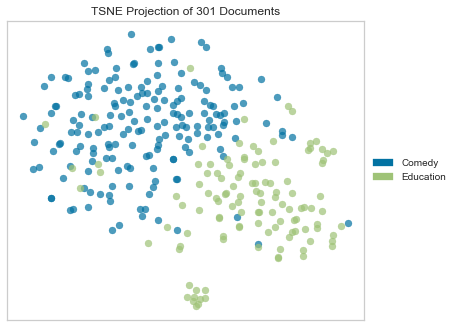

<AxesSubplot:title={'center':'TSNE Projection of 301 Documents'}>

In [52]:
tsne_check_bw_two_categories('Comedy','Education', df_minilm_embeddings)

**Works quite well** since the categories are quite well seperated

# Now Let's take any one categories and do a quantitative check of similarities with a category

In [53]:
def sim_check_within_categories(cat,df):
    df_subset = df[df['category'] == cat]
    sim_within_category = cosine_similarity(df_subset.iloc[:,3:])
    
    plt.figure(figsize=(10,10))
    sns.heatmap(sim_within_category)
    return plt.show()

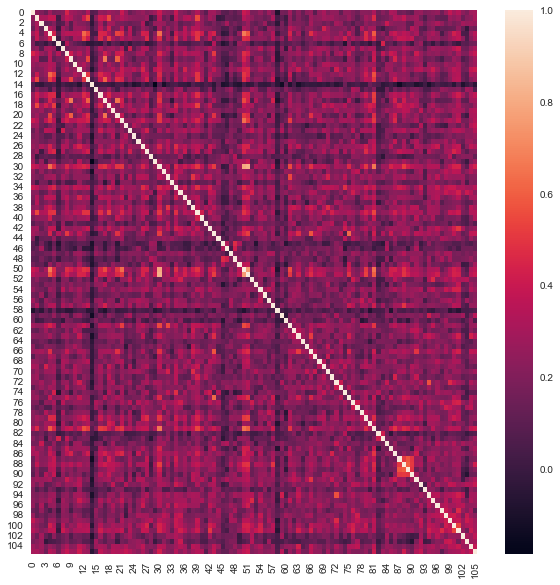

In [54]:
sim_check_within_categories('Fiction',df_minilm_embeddings)

# Two category comparison

In [56]:
def sim_check_bw_two_categories(cat_1,cat_2, df):
    df_subset = df[df['category'].isin([cat_1,cat_2])]
    
    df_subset = df_subset.sample(200)
    df_subset.sort_values('category',inplace=True)
    
    sim_between_category = cosine_similarity(df_subset.iloc[:,3:])
    
    plt.figure(figsize=(10,10))
    sns.heatmap(sim_between_category)
    return plt.show()

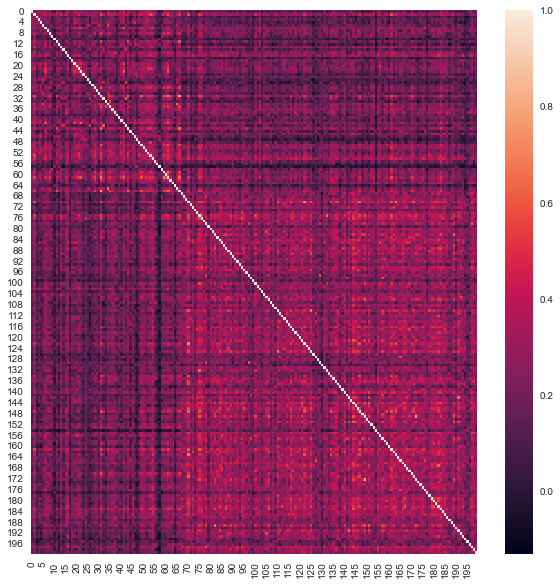

In [57]:
sim_check_bw_two_categories('News','Education', df_minilm_embeddings)

# Pairwise comparison between all the categories

In [60]:
def get_cosine_sim(df, row1, row2):
    ep1 = df[df.columns[4:]].iloc[row1]
    ep2 = df[df.columns[4:]].iloc[row2]
    return cosine_similarity(ep1.values.reshape(1,-1), ep2.values.reshape(1,-1))

In [62]:
sample_size = 30
sampled_categories_df = df_minilm_embeddings.groupby('category').apply(lambda x: x.sample(sample_size))

In [63]:
import itertools

category_pair_sims = {}

for category_pair in tqdm(itertools.combinations(sampled_categories_df.category.unique(), 2)):
    paired_category_df = sampled_categories_df[sampled_categories_df.category.isin(category_pair)]
#    category_pair_sim_matrix = np.zeros((sample_size*2, sample_size*2))
    category_pair_sims[category_pair] = cosine_similarity(paired_category_df.iloc[:,3:])

171it [00:00, 1708.38it/s]


In [15]:
import itertools

category_pair_sims = {}

for category_pair in itertools.combinations(sampled_categories_df.category.unique(), 2):
    paired_category_df = sampled_categories_df[sampled_categories_df.category.isin(category_pair)]
    category_pair_sim_matrix = np.zeros((sample_size*2, sample_size*2))
    for i in tqdm(range(len(paired_category_df))):
        for j in range(len(paired_category_df)):
            category_pair_sim_matrix[i,j] = get_cosine_sim(paired_category_df, i, j)
    category_pair_sims[category_pair] = category_pair_sim_matrix

100%|███████████████████████████████████████████| 60/60 [00:02<00:00, 26.46it/s]


100%|███████████████████████████████████████████| 60/60 [00:02<00:00, 26.54it/s]


In [64]:
np.save('categorypair_sim_matrices.npy',category_pair_sims)

In [65]:
def get_selfsim_diffsim(sim_matrix_dict, category1, category2, sample_size):
    '''
    Takes in the similarity matrix of two different categories and returns the within-category and between-category similarities
    '''
    sim_matrix = sim_matrix_dict[category1, category2]
    
    triu_idx_selfsim = np.triu_indices(sample_size, k=1)
    triu_idx_diffsim = np.triu_indices(sample_size)
    
    cat1_selfsim = np.triu(sim_matrix[:sample_size, :sample_size], k=1)
    cat2_selfsim = np.triu(sim_matrix[sample_size:, sample_size:], k=1)
    
    cat1_selfsim = cat1_selfsim[triu_idx_selfsim]
    cat2_selfsim = cat2_selfsim[triu_idx_selfsim]
    
    cat1_cat2_diffsim = np.triu(sim_matrix[sample_size:, :sample_size])
    cat1_cat2_diffsim = cat1_cat2_diffsim[triu_idx_diffsim]
    
    return {category1:cat1_selfsim, category2:cat2_selfsim, (category1,category2):cat1_cat2_diffsim}

In [66]:
from scipy.stats import ttest_ind

ttest_comparisons_tstat = np.zeros((len(sampled_categories_df.category.unique()), len(sampled_categories_df.category.unique())))
ttest_comparisons_pval = np.zeros((len(sampled_categories_df.category.unique()), len(sampled_categories_df.category.unique())))

for i, category1 in enumerate(sampled_categories_df.category.unique()): 
    for j, category2 in enumerate(sampled_categories_df.category.unique()):
        if i == j:
            ttest_comparisons_tstat[i,j] = 0
            ttest_comparisons_pval[i,j] = 1
        else:
            ordered_categories = tuple(sorted([category1, category2]))
            self_diff_sims = get_selfsim_diffsim(category_pair_sims, ordered_categories[0], ordered_categories[1], sample_size)
            ttest_result = ttest_ind(self_diff_sims[ordered_categories], self_diff_sims[category1], equal_var=False, alternative='less')
            ttest_comparisons_tstat[i,j] = ttest_result.statistic
            ttest_comparisons_pval[i,j] = ttest_result.pvalue

In [67]:
from matplotlib.colors import from_levels_and_colors

colors_tstat = sns.color_palette('BuPu', 6)
levels_tstat = [-10,-2,0,2,10]
cmap_tstat, norm_tstat = from_levels_and_colors(levels_tstat, colors_tstat, extend='both')

colors_pval = sns.color_palette('BuPu',3)
levels_pval = [0,0.05,1]
cmap_pval, norm_pval = from_levels_and_colors(levels_pval, colors_pval, extend='max')

/var/folders/hk/dkqk41797ls590n4w_sfpy180000gn/T/ipykernel_79996/342805875.py:5: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  fig.colorbar(im,cmap=cmap_tstat, spacing='proportional')


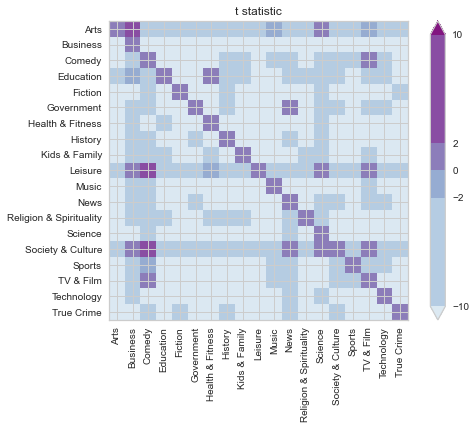

/var/folders/hk/dkqk41797ls590n4w_sfpy180000gn/T/ipykernel_79996/342805875.py:13: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  fig.colorbar(im, cmap=cmap_pval, spacing='proportional')


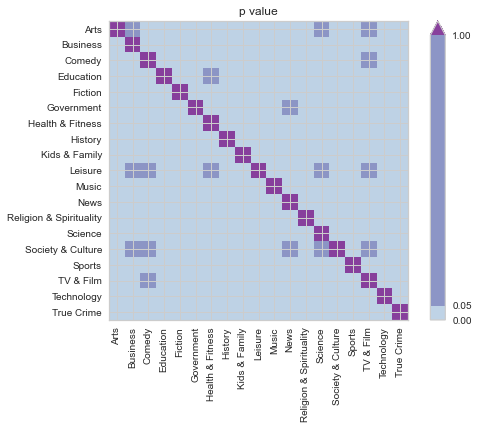

In [68]:
fig, ax = plt.subplots()
im = ax.imshow(ttest_comparisons_tstat, cmap=cmap_tstat, norm=norm_tstat)
ax.set_xticks(range(len(sampled_categories_df.category.unique())),labels=sampled_categories_df.category.unique(), rotation=90)
ax.set_yticks(range(len(sampled_categories_df.category.unique())),labels=sampled_categories_df.category.unique())
fig.colorbar(im,cmap=cmap_tstat, spacing='proportional')
plt.title('t statistic')
plt.show()

fig, ax = plt.subplots()
im = ax.imshow(ttest_comparisons_pval, cmap=cmap_pval, norm=norm_pval)
plt.xticks(range(len(sampled_categories_df.category.unique())),labels=sampled_categories_df.category.unique(), rotation=90)
plt.yticks(range(len(sampled_categories_df.category.unique())),labels=sampled_categories_df.category.unique())
fig.colorbar(im, cmap=cmap_pval, spacing='proportional')
plt.title('p value')
plt.show()

In [69]:
print('Proportion of ordered category pairs where within-category cosine similarity > between-category cosine similarity:')
# print(f'{np.sum(ttest_comparisons_pval < .05)/ttest_comparisons_tstat.flatten().shape[0]:.3f}')

upper_tri_pvals = ttest_comparisons_pval[np.triu_indices(ttest_comparisons_pval.shape[0], k=1)].flatten()
lower_tri_pvals = ttest_comparisons_pval[np.tril_indices(ttest_comparisons_pval.shape[0], k=-1)].flatten()

np.sum(np.concatenate([upper_tri_pvals < .05, lower_tri_pvals < .05]))/np.concatenate([upper_tri_pvals < .05, lower_tri_pvals < .05]).shape[0]



Proportion of ordered category pairs where within-category cosine similarity > between-category cosine similarity:


0.9502923976608187

# Cross Validation

In [70]:
accuracy = []

for cv in range(100):
    sample_size = 30
    sampled_categories_df = df_minilm_embeddings.groupby('category').apply(lambda x: x.sample(sample_size))
    
    import itertools

    category_pair_sims = {}

    for category_pair in tqdm(itertools.combinations(sampled_categories_df.category.unique(), 2)):
        paired_category_df = sampled_categories_df[sampled_categories_df.category.isin(category_pair)]
#    category_pair_sim_matrix = np.zeros((sample_size*2, sample_size*2))
        category_pair_sims[category_pair] = cosine_similarity(paired_category_df.iloc[:,3:])
    
    
    
    ttest_comparisons_tstat = np.zeros((len(sampled_categories_df.category.unique()), len(sampled_categories_df.category.unique())))
    ttest_comparisons_pval = np.zeros((len(sampled_categories_df.category.unique()), len(sampled_categories_df.category.unique())))

    for i, category1 in enumerate(sampled_categories_df.category.unique()): 
        for j, category2 in enumerate(sampled_categories_df.category.unique()):
            if i == j:
                ttest_comparisons_tstat[i,j] = 0
                ttest_comparisons_pval[i,j] = 1
            else:
                ordered_categories = tuple(sorted([category1, category2]))
                self_diff_sims = get_selfsim_diffsim(category_pair_sims, ordered_categories[0], ordered_categories[1], sample_size)
                ttest_result = ttest_ind(self_diff_sims[ordered_categories], self_diff_sims[category1], equal_var=False, alternative='less')
                ttest_comparisons_tstat[i,j] = ttest_result.statistic
                ttest_comparisons_pval[i,j] = ttest_result.pvalue
            
            
            
#    print('Proportion of ordered category pairs where within-category cosine similarity > between-category cosine similarity:')
# print(f'{np.sum(ttest_comparisons_pval < .05)/ttest_comparisons_tstat.flatten().shape[0]:.3f}')

    upper_tri_pvals = ttest_comparisons_pval[np.triu_indices(ttest_comparisons_pval.shape[0], k=1)].flatten()
    lower_tri_pvals = ttest_comparisons_pval[np.tril_indices(ttest_comparisons_pval.shape[0], k=-1)].flatten()

    accuracy.append(np.sum(np.concatenate([upper_tri_pvals < .05, lower_tri_pvals < .05]))/np.concatenate([upper_tri_pvals < .05, lower_tri_pvals < .05]).shape[0])
    print(cv)
           
    

171it [00:00, 2038.29it/s]


0


171it [00:00, 2446.46it/s]


1


171it [00:00, 2488.68it/s]


2


171it [00:00, 2399.90it/s]


3


171it [00:00, 2419.83it/s]


4


171it [00:00, 2483.73it/s]


5


171it [00:00, 2359.56it/s]


6


171it [00:00, 2415.21it/s]


7


171it [00:00, 2413.21it/s]


8


171it [00:00, 2447.54it/s]


9


171it [00:00, 2414.88it/s]


10


171it [00:00, 2474.07it/s]


11


171it [00:00, 2470.78it/s]


12


171it [00:00, 2450.52it/s]


13


171it [00:00, 2498.94it/s]


14


171it [00:00, 2482.28it/s]


15


171it [00:00, 2497.99it/s]


16


171it [00:00, 2479.40it/s]


17


171it [00:00, 2476.97it/s]


18


171it [00:00, 2498.38it/s]


19


171it [00:00, 2491.36it/s]


20


171it [00:00, 2410.32it/s]


21


171it [00:00, 2361.09it/s]


22


171it [00:00, 2491.19it/s]


23


171it [00:00, 2472.34it/s]


24


171it [00:00, 2365.73it/s]


25


171it [00:00, 2364.72it/s]


26


171it [00:00, 2333.74it/s]


27


171it [00:00, 2378.61it/s]


28


171it [00:00, 2473.06it/s]


29


171it [00:00, 2260.35it/s]


30


171it [00:00, 2375.33it/s]


31


171it [00:00, 2419.70it/s]


32


171it [00:00, 2351.81it/s]


33


171it [00:00, 2402.80it/s]


34


171it [00:00, 2454.45it/s]


35


171it [00:00, 2483.99it/s]


36


171it [00:00, 2441.74it/s]


37


171it [00:00, 2456.55it/s]


38


171it [00:00, 2430.39it/s]


39


171it [00:00, 2471.53it/s]


40


171it [00:00, 2438.39it/s]


41


171it [00:00, 2331.25it/s]


42


171it [00:00, 2398.58it/s]


43


171it [00:00, 2406.86it/s]


44


171it [00:00, 2417.99it/s]


45


171it [00:00, 2453.93it/s]


46


171it [00:00, 2500.43it/s]


47


171it [00:00, 2512.70it/s]


48


171it [00:00, 2508.36it/s]


49


171it [00:00, 1854.98it/s]

50



171it [00:00, 2291.60it/s]


51


171it [00:00, 2459.62it/s]


52


171it [00:00, 2496.93it/s]


53


171it [00:00, 2432.49it/s]


54


171it [00:00, 2510.90it/s]


55


171it [00:00, 2464.73it/s]


56


171it [00:00, 2341.86it/s]


57


171it [00:00, 2035.89it/s]


58


171it [00:00, 1809.14it/s]


59


171it [00:00, 2240.60it/s]


60


171it [00:00, 2351.56it/s]


61


171it [00:00, 2365.67it/s]


62


171it [00:00, 2496.20it/s]


63


171it [00:00, 2367.37it/s]


64


171it [00:00, 2404.39it/s]


65


171it [00:00, 2445.76it/s]


66


171it [00:00, 2470.25it/s]


67


171it [00:00, 2493.29it/s]


68


171it [00:00, 2508.29it/s]


69


171it [00:00, 2498.21it/s]


70


171it [00:00, 2341.76it/s]


71


171it [00:00, 1640.89it/s]


72


171it [00:00, 2311.75it/s]


73


171it [00:00, 2306.23it/s]


74


171it [00:00, 2465.91it/s]


75


171it [00:00, 2160.13it/s]


76


171it [00:00, 2410.66it/s]


77


171it [00:00, 1824.45it/s]

78



171it [00:00, 2346.13it/s]


79


171it [00:00, 2381.58it/s]


80


171it [00:00, 2276.39it/s]


81


171it [00:00, 2028.52it/s]


82


171it [00:00, 2482.51it/s]


83


171it [00:00, 2498.87it/s]


84


171it [00:00, 2496.11it/s]


85


171it [00:00, 2438.44it/s]


86


171it [00:00, 2463.93it/s]


87


171it [00:00, 2495.04it/s]


88


171it [00:00, 2499.56it/s]


89


171it [00:00, 2502.27it/s]


90


171it [00:00, 2484.13it/s]


91


171it [00:00, 2502.63it/s]


92


171it [00:00, 2520.60it/s]


93


171it [00:00, 2496.57it/s]


94


171it [00:00, 2467.36it/s]


95


171it [00:00, 2439.44it/s]


96


171it [00:00, 2483.70it/s]


97


171it [00:00, 2474.02it/s]


98


171it [00:00, 2467.42it/s]


99


In [71]:
accuracy = np.mean(np.array(accuracy))
accuracy

0.956374269005848